In [27]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import cv2
import csv
import random
import h5py
from PIL import Image
import random
import os

import model

# Behavioral Cloning Project

My project includes the following files:
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.json is the structure of the model
* model.h5 containing a trained convolution neural network weights
* writeup_report.md summarizing the results
* train.ipynb is a Jupyter notebook I used to evaluate preprocessing

The model can be run with:
```sh
python drive.py model.json
```

### 1. Solution Design Approach

To capture high-level patterns, I knew that I would need a convolutional neural network. I first tried transfer learning on VGG and Inception models, but these were slow and performed poorly. I then experimented with my own model, but found the NVIDIA model and decided to try that.

The model consists of a convolution neural network with 5x5 and 3x3 filter sizes and depths between 24 and 64 (model.py lines 90-117)

First, there are five convolutions, each with RELU activations. These are flattened into a vector and passed to densely connected layers.

The model then uses five densely connected layers with RELU activations to introduce non-linearities. These are combined into a single output, which represents the steering angle.

After the first and second dense layers I introduced dropout layers to help prevent overfitting in the model.

Below is a summary of the model:

In [28]:
m = model.steering_model()
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1_1 (Convolution2D)          (None, 48, 98, 24)    1824        convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
conv2_1 (Convolution2D)          (None, 22, 47, 36)    21636       conv1_1[0][0]                    
____________________________________________________________________________________________________
conv3_1 (Convolution2D)          (None, 9, 22, 48)     43248       conv2_1[0][0]                    
____________________________________________________________________________________________________
conv4_1 (Convolution2D)          (None, 7, 20, 64)     27712       conv3_1[0][0]                    
___________________________________________________________________________________________

### 2. Creation of the Training Set

I drove the car around the track a few times, then tried to record recovery from the sides. I tried removing some of the zero-angle data points, as this biases the car towards no steering, which can lead it to going off the track. Below is a summary of the training data that I obtained:

Creating data
37776
4197
Done creating data
37776 training samples, 4197 validation samples


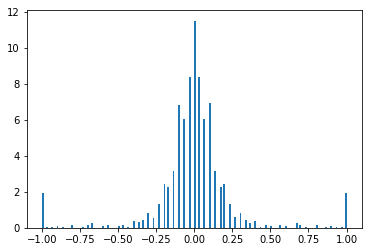

In [29]:
train, valid = model.create_data()
angles = [row['steering'] for row in train]
x = plt.hist(angles, bins='auto', normed=True)
print("{} training samples, {} validation samples".format(len(train), len(valid)))

Below are some example recovery images:

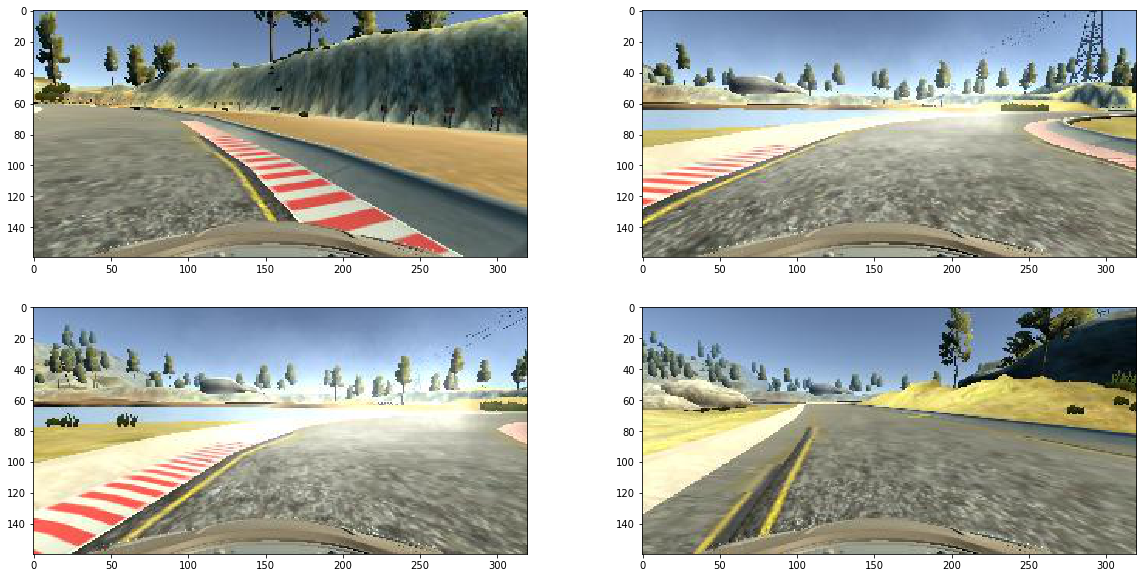

In [30]:
recovery = [row for row in train if row['steering'] == 1]
random.shuffle(recovery)
fig, axs = plt.subplots(2, 2, figsize=(20,10))
cnt = 0
for ax in axs:
    for x in ax:
        img = scipy.ndimage.imread(recovery[cnt]['img'])
        x.imshow(img)
        cnt += 1
plt.show()

I augmented the data by flipping the images horizontally, and changing the sign of the steering angle. Images were resized to reduce high-frequency components and to also speed up training. I also cropped out the horizon, to prevent the model from fitting to irrelevant details.

Steering angle: 0.1


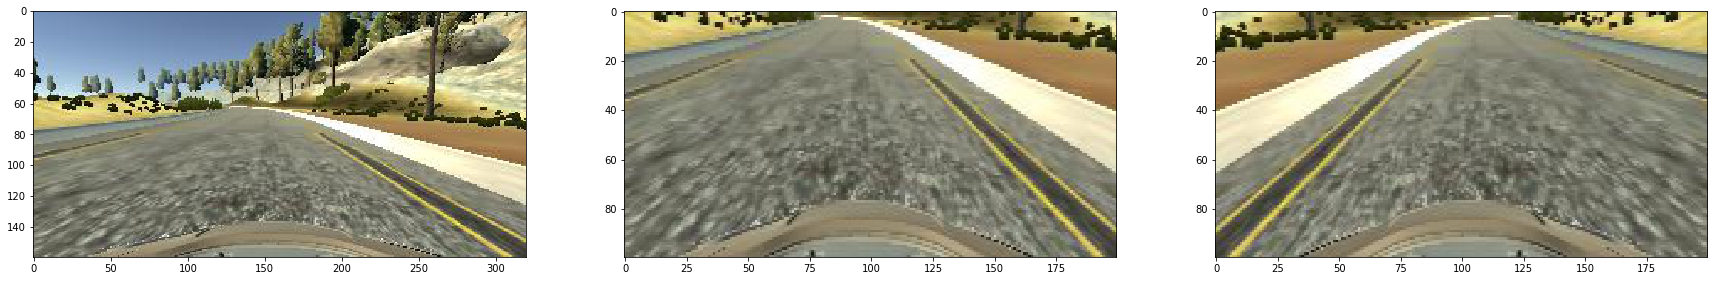

In [31]:
rownum = 900
img = scipy.ndimage.imread(train[rownum]['img'])

print("Steering angle: {}".format(train[rownum]['steering']))
fig, axs = plt.subplots(1, 3, figsize=(30,30))
axs[0].imshow(img)
axs[1].imshow(model.preprocess(img))
axs[2].imshow(np.fliplr(model.preprocess(img)))
plt.show()


### Training and evaluation
I compiled my model to use the Mean Squared Error loss functions and to use the Adam optimizer, so to not need to change the learning rate. I found that 5 epochs resulted in a properly trained model. I also used the ModelCheckpoint callback to save the model each time the validation score was lowered, ensuring that I only obtained good models.

I tested the trained model in the simulator. The car was able to complete the course for multiple laps